In [1]:
#da usare per evitare problemi con la GPU
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Riduce i warning
import pennylane as qml
from pennylane import numpy as np
from pennylane. templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-12-11 00:58:38.043457: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 00:58:38.242404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 00:58:40.465503: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [15]:
# =============================================================================
# TEST CUDA/cuDNN CONFIGURATION
# =============================================================================

print("=" * 60)
print("CUDA/cuDNN DIAGNOSTIC")
print("=" * 60)

# 1. Versione TensorFlow e build info
print("\n[1] TENSORFLOW INFO")
print("-" * 40)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"Built with GPU support: {tf.test.is_built_with_gpu_support()}")

# 2. Versioni CUDA/cuDNN con cui TensorFlow è stato compilato
print("\n[2] TF BUILD CONFIGURATION")
print("-" * 40)
try:
    from tensorflow.python.platform import build_info
    print(f"CUDA version (build): {build_info.build_info.get('cuda_version', 'N/A')}")
    print(f"cuDNN version (build): {build_info.build_info.get('cudnn_version', 'N/A')}")
except:
    print("Build info not available")

# 3. GPU rilevate da TensorFlow
print("\n[3] GPU DEVICES")
print("-" * 40)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"  {gpu}")
        # Dettagli GPU
        try:
            details = tf.config.experimental.get_device_details(gpu)
            print(f"    Name: {details.get('device_name', 'N/A')}")
            print(f"    Compute capability: {details.get('compute_capability', 'N/A')}")
        except:
            pass
else:
    print("  No GPU detected")

# 4. Verifica cuDNN runtime
print("\n[4] cuDNN RUNTIME CHECK")
print("-" * 40)
try:
    # Questo forza il caricamento di cuDNN
    from tensorflow.python.framework import test_util
    print(f"cuDNN enabled: {tf.test.is_built_with_cuda()}")
    
    # Test effettivo creando una operazione che usa cuDNN
    if gpus:
        try:
            with tf.device('/GPU:0'):
                # Operazione che richiede cuDNN
                x = tf.random.normal([1, 28, 28, 1])
                conv = tf.keras.layers.Conv2D(32, 3, padding='same')
                _ = conv(x)
            print("cuDNN test: PASSED ✓")
        except Exception as e:
            print(f"cuDNN test: FAILED ✗")
            print(f"  Error: {e}")
except Exception as e:
    print(f"Error: {e}")

# 5. Versione CUDA dal sistema (nvidia-smi)
print("\n[5] SYSTEM CUDA (nvidia-smi)")
print("-" * 40)
import subprocess
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    # Estrai la riga con CUDA Version
    for line in result.stdout.split('\n'):
        if 'CUDA Version' in line:
            print(f"  {line.strip()}")
            break
    # Driver version
    for line in result.stdout.split('\n'):
        if 'Driver Version' in line:
            print(f"  {line.strip()}")
            break
except FileNotFoundError:
    print("  nvidia-smi not found")

# 6. Verifica cuDNN da file system
print("\n[6] cuDNN LIBRARY FILES")
print("-" * 40)
import os
import glob

cudnn_paths = [
    '/usr/lib/x86_64-linux-gnu/libcudnn*',
    '/usr/local/cuda/lib64/libcudnn*',
    os.path.expanduser('~/anaconda3/envs/*/lib/libcudnn*'),
    os.path.expanduser('~/miniconda3/envs/*/lib/libcudnn*'),
]

found = False
for pattern in cudnn_paths:
    files = glob.glob(pattern)
    for f in files:
        if 'libcudnn.so' in f or 'libcudnn_' in f:
            print(f"  {f}")
            found = True

if not found:
    print("  No cuDNN libraries found in common paths")

# 7. Variabili d'ambiente rilevanti
print("\n[7] ENVIRONMENT VARIABLES")
print("-" * 40)
env_vars = ['CUDA_HOME', 'CUDA_PATH', 'LD_LIBRARY_PATH', 'CUDNN_PATH', 
            'CUDA_VISIBLE_DEVICES', 'TF_FORCE_GPU_ALLOW_GROWTH']
for var in env_vars:
    val = os.environ.get(var, 'not set')
    if len(str(val)) > 50:
        val = val[:50] + '...'
    print(f"  {var}: {val}")

# 8. Raccomandazioni
print("\n" + "=" * 60)
print("RECOMMENDATIONS")
print("=" * 60)

try:
    cuda_build = build_info.build_info.get('cuda_version', '')
    cudnn_build = build_info.build_info.get('cudnn_version', '')
    
    print(f"\nYour TensorFlow {tf.__version__} requires:")
    print(f"  - CUDA: {cuda_build}")
    print(f"  - cuDNN: {cudnn_build}")
    
    print(f"\nTo fix cuDNN mismatch, run:")
    print(f"  conda install cudnn={cudnn_build[:3]}* -c conda-forge")
    print(f"\nOr to use CPU only, add at the start of your script:")
    print(f"  import os")
    print(f"  os.environ['CUDA_VISIBLE_DEVICES'] = '-1'")
except:
    pass

CUDA/cuDNN DIAGNOSTIC

[1] TENSORFLOW INFO
----------------------------------------
TensorFlow version: 2.20.0
Built with CUDA: True
Built with GPU support: True

[2] TF BUILD CONFIGURATION
----------------------------------------
CUDA version (build): 12.5.1
cuDNN version (build): 9

[3] GPU DEVICES
----------------------------------------
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
    Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
    Compute capability: (8, 6)

[4] cuDNN RUNTIME CHECK
----------------------------------------
cuDNN enabled: True
cuDNN test: PASSED ✓

[5] SYSTEM CUDA (nvidia-smi)
----------------------------------------
  | NVIDIA-SMI 470.256.02   Driver Version: 572.60       CUDA Version: 12.8     |
  | NVIDIA-SMI 470.256.02   Driver Version: 572.60       CUDA Version: 12.8     |

[6] cuDNN LIBRARY FILES
----------------------------------------
  /usr/lib/x86_64-linux-gnu/libcudnn_adv.so.9
  /usr/lib/x86_64-linux-gnu/libcudnn_graph_static_v9.a
  

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50   # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "./QUANVOLUTION/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

In [4]:
# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [5]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


In [6]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [7]:
 if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)   


Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
30/30        

In [8]:
# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

In [9]:
print(SAVE_PATH)

./QUANVOLUTION/


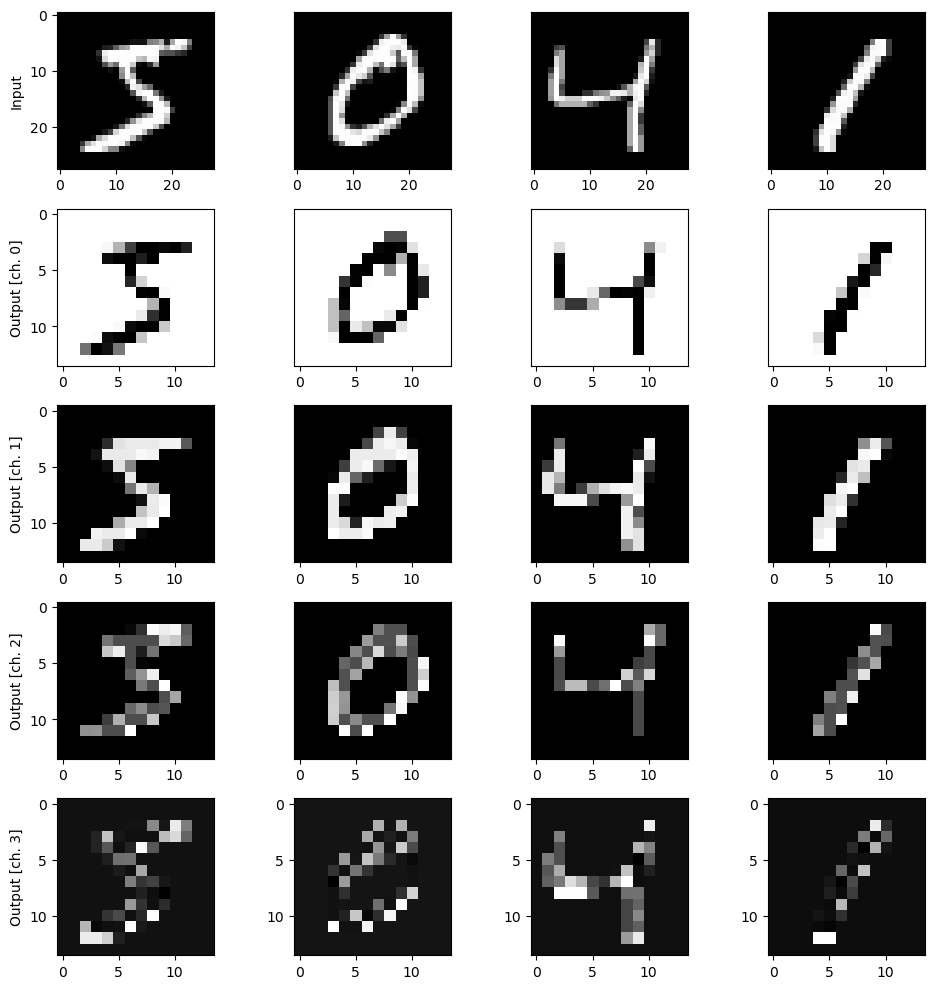

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [12]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    #epochs=n_epochs,
    epochs=50,
    verbose=2,
)

I0000 00:00:1765411195.590031  210254 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


2025-12-11 00:59:56.840091: I external/local_xla/xla/service/service.cc:163] XLA service 0x78a064017ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-11 00:59:56.840138: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-12-11 00:59:56.865399: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-11 00:59:56.978173: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-12-11 00:59:58.121220: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_61', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1765411198.873497  210327 device_compiler.h:196] Compiled cluster using XLA!  This line i

13/13 - 5s - 353ms/step - accuracy: 0.1400 - loss: 2.8130 - val_accuracy: 0.2000 - val_loss: 2.3420
Epoch 2/50
13/13 - 0s - 13ms/step - accuracy: 0.2600 - loss: 2.0849 - val_accuracy: 0.1333 - val_loss: 2.2310
Epoch 3/50
13/13 - 0s - 13ms/step - accuracy: 0.4000 - loss: 1.7623 - val_accuracy: 0.3000 - val_loss: 2.0489
Epoch 4/50
13/13 - 0s - 15ms/step - accuracy: 0.6400 - loss: 1.4177 - val_accuracy: 0.3667 - val_loss: 1.8554
Epoch 5/50
13/13 - 0s - 13ms/step - accuracy: 0.8000 - loss: 1.1676 - val_accuracy: 0.5000 - val_loss: 1.7360
Epoch 6/50
13/13 - 0s - 13ms/step - accuracy: 0.9200 - loss: 0.9697 - val_accuracy: 0.4667 - val_loss: 1.6345
Epoch 7/50
13/13 - 0s - 13ms/step - accuracy: 0.9600 - loss: 0.8073 - val_accuracy: 0.4667 - val_loss: 1.5450
Epoch 8/50
13/13 - 0s - 13ms/step - accuracy: 0.9800 - loss: 0.6812 - val_accuracy: 0.5333 - val_loss: 1.4739
Epoch 9/50
13/13 - 0s - 17ms/step - accuracy: 1.0000 - loss: 0.5798 - val_accuracy: 0.6333 - val_loss: 1.4143
Epoch 10/50
13/13 - 

In [13]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    #epochs=n_epochs,
    epochs=50,
    verbose=2,
)

Epoch 1/50


2025-12-11 01:00:10.591672: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_61', 8 bytes spill stores, 8 bytes spill loads

2025-12-11 01:00:11.851674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_61', 8 bytes spill stores, 8 bytes spill loads



13/13 - 4s - 331ms/step - accuracy: 0.1400 - loss: 2.4653 - val_accuracy: 0.1333 - val_loss: 2.2761
Epoch 2/50
13/13 - 0s - 14ms/step - accuracy: 0.3400 - loss: 2.0341 - val_accuracy: 0.2333 - val_loss: 2.1195
Epoch 3/50
13/13 - 0s - 15ms/step - accuracy: 0.5600 - loss: 1.7403 - val_accuracy: 0.3333 - val_loss: 1.9774
Epoch 4/50
13/13 - 0s - 15ms/step - accuracy: 0.7200 - loss: 1.4980 - val_accuracy: 0.3667 - val_loss: 1.8444
Epoch 5/50
13/13 - 0s - 14ms/step - accuracy: 0.8000 - loss: 1.2919 - val_accuracy: 0.4000 - val_loss: 1.7265
Epoch 6/50
13/13 - 0s - 15ms/step - accuracy: 0.8800 - loss: 1.1183 - val_accuracy: 0.5000 - val_loss: 1.6274
Epoch 7/50
13/13 - 0s - 15ms/step - accuracy: 0.9200 - loss: 0.9733 - val_accuracy: 0.5667 - val_loss: 1.5459
Epoch 8/50
13/13 - 0s - 15ms/step - accuracy: 0.9400 - loss: 0.8524 - val_accuracy: 0.6000 - val_loss: 1.4786
Epoch 9/50
13/13 - 0s - 15ms/step - accuracy: 0.9400 - loss: 0.7511 - val_accuracy: 0.6000 - val_loss: 1.4224
Epoch 10/50
13/13 - 

In [18]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


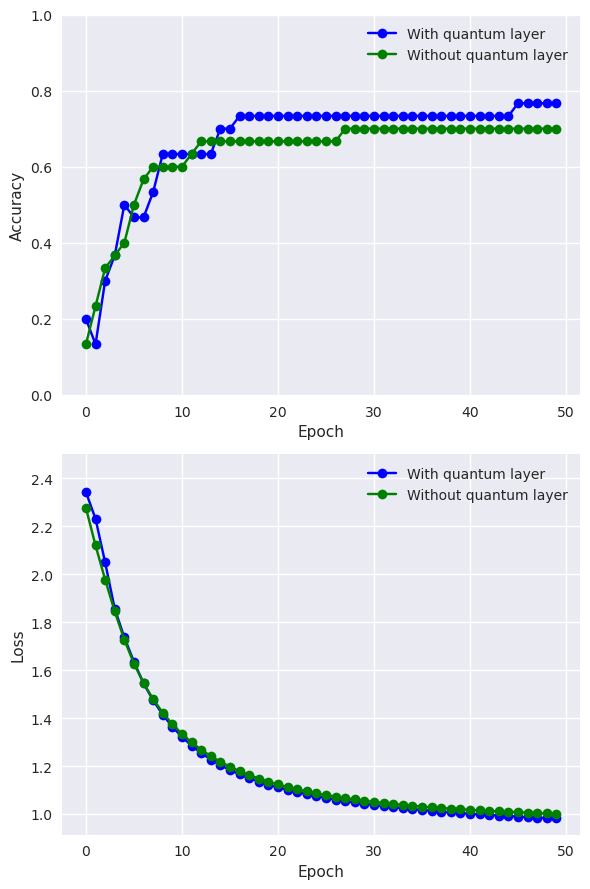

In [20]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()